# Обучение и визуализация дерева решений

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

In [2]:
 
iris = load_iris(as_frame=True) 
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values 
y_iris = iris.target

In [3]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

можно визуализировать обученное дерево решений, сначала используя export_graphviz() функцию для вывода файла определения графа с именем iris_tree.dot : 

In [4]:
from sklearn.tree import export_graphviz
from graphviz import Source

In [5]:
export_graphviz( 
        tree_clf, 
        out_file="iris_tree.dot", 
        feature_names=["petal length (cm)", "petal width (cm)"], 
        class_names=iris.target_names, 
        rounded=True, 
        filled=True 
    )

In [6]:
! pip install graphviz

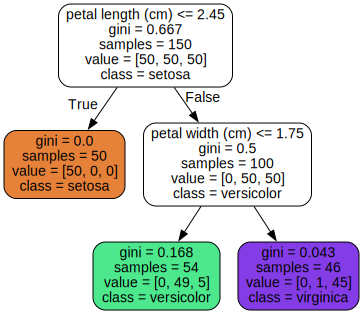

In [7]:
Source.from_file('iris_tree.dot')

In [10]:
print(tree_clf.predict_proba([[5, 1.5]]).round(3))
print(tree_clf.predict([[5, 1.5]]))


[[0.    0.907 0.093]]
[1]


Алгоритм обучения сравнивает все признаки (или меньше, если max_features он установлен) на всех образцах в каждом узле.

Cледует ли использовать примесь Джини или энтропию? Правда в том, что в большинстве случаев это не имеет большого значения: они ведут к похожим деревьям. Примесь Джини вычисляется немного быстрее, поэтому это хорошее значение по умолчанию. Однако, когда они различаются, примесь Джини имеет тенденцию изолировать наиболее часто встречающийся класс в своей собственной ветви дерева, в то время как энтропия имеет тенденцию создавать несколько более сбалансированные деревья.

 Регурялизация устанавливается гиперпараметром max_depth. Значение по умолчанию равно None, что означает неограниченное количество. Сокращение max_depth упорядочит модель и, таким образом, снизит риск переобучения. 

У DecisionTreeClassifier класса есть несколько других параметров, которые аналогичным образом ограничивают форму дерева решений: 

- max_features 

Максимальное количество объектов, которые оцениваются для разделения в каждом узле 

- max_leaf_nodes 

Максимальное количество конечных узлов 

- min_samples_split 

Минимальное количество выборок, которое должен иметь узел, прежде чем его можно будет разделить 

- min_samples_leaf 

Минимальное количество образцов, которое должен быть создан листовым узлом 

- min_weight_fraction_leaf 

То же, min_samples_leaf но выражено в виде доли от общего количества взвешенных экземпляров 

**Увеличение min_гиперпараметров или уменьшение max_гиперпараметров приведет к упорядочению модели.**

# Регрессия

In [11]:
import numpy as np 
from sklearn.tree import DecisionTreeRegressor

In [12]:
np.random.seed(42) 
X_quad = np.random.rand(200, 1) - 0.5  # одна функция случайного ввода
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1) 
 
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42) 
tree_reg.fit(X_quad, y_quad) 

DecisionTreeRegressor(max_depth=2, random_state=42)

In [13]:
export_graphviz( 
        tree_reg, 
        out_file="reg.dot", 
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

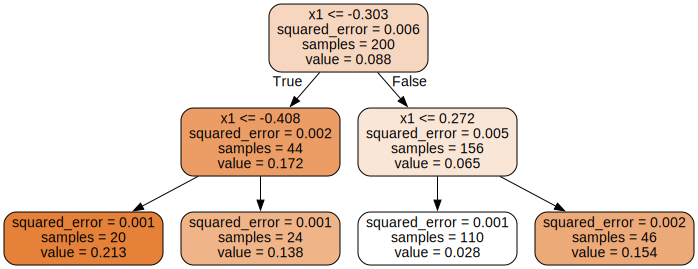

In [14]:
Source.from_file('reg.dot')

# Масштабирование

In [16]:
from sklearn.decomposition import PCA # вращает данные таким образом, чтоб уменьшить корреляцию между функциями, 
# это часто (не всегда) упрощает работу с деревьями.
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler

In [17]:
pca_pipeline = make_pipeline(StandardScaler(), PCA()) 
X_iris_rotated = pca_pipeline.fit_transform(X_iris) 
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42) 
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

В более общем плане основная проблема с деревьями решений заключается в том, что они имеют довольно высокую дисперсию: небольшие изменения гиперпараметров или данных могут привести к очень разным моделям. 

К счастью, усредняя прогнозы по множеству деревьев, можно значительно уменьшить дисперсию. Такой ансамбль деревьев называется случайным лесом.

# Интересные вопросы 

- Какова приблизительная глубина дерева решений, обученного (без ограничений) на обучающем множестве с миллионом экземпляров? 

(ответ: глубина хорошо сбалансированного бинарного дерева, содержащего m листьев, равна log₂(m), округленному в большую сторону. Бинарное дерево решений (которое принимает только бинарные решения, как в случае со всеми деревьями в Scikit-Learn) в конечном итоге будет более или менее хорошо сбалансированным в конце обучения, с одним листом на экземпляр обучения, если оно обучается без ограничений. Таким образом, если обучающая выборка содержит один миллион экземпляров, дерево решений будет иметь глубину log₂(106) ≈ 20 (на самом деле немного больше, поскольку дерево, как правило, не будет идеально сбалансированным)). 

- Является ли примесь Джини узла обычно ниже или выше, чем у его родителя? Обычно она ниже/выше или всегда ниже/выше? 

(ответ: примесь Джини обычно ниже, чем у родителя, это связано с алгоритмом обучения, который стремится минимизировать взвешенную сумму дочерних примесей. Однако, узел может иметь более высокую примесь Джини, чем родитель, если это компенсируется достаточным уменьшением другого дочернего узла. Например, возьмем узел, содержащий четыре экземпляра А и один экземпляр Б. Примесь Джинни этого узла равна : 1-(4/5)2 - (1/5)2 = 0,32. Если данные расположены в следующем порядке А, Б, А, А, А, то разделение будет сразу после второго экземпляра. Будет создано два дочерних узла с экземплярами А, Б и экземплярами А, А, А. Примесь Джини первого узла составит 1-(½)2 -(½)2 = 0,5, что выше, чем у родителя, а примесь Джини второго узла = 0 (узел чистый). При этом общая примесь Джини составит 2/5*0,5 + 3/5*0 =0,2, что ниже, чем примесь родителя.) 

- Если дерево решений переобучает обучающую выборку, стоит ли пытаться уменьшить max_depth? 

(ответ: да, так как это ограничит модель, упорядочив её). 

- Если дерево решений не соответствует обучающему набору, стоит ли пытаться масштабировать входные признаки? 

(ответ: нет,  для этой модели не требуется масштабирования или центрирования признаков) 

- Если обучение дерева решений на заданном обучающем наборе занимает один час, сколько примерно времени потребуется, если вы удвоите количество признаков? 

(ответ:если количество признаков удвоится, то и время обучения удвоится) 

Обучите и настройте дерево решений для набора данных лун, выполнив следующие действия: 

In [18]:
from sklearn.datasets import make_moons 
 
X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42) 


In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train_moon, X_test_moon, y_train_moon, y_test_moon = train_test_split(X_moons, y_moons, random_state = 42, test_size = 0.25, stratify=y_moons)

In [ ]:
param = {'max_depth': list(range(2,100)),
         'max_leaf_nodes': list(range(1, 7)),
         'min_samples_split': [2, 3, 4]
         }

model_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param, cv=5)
model_grid.fit(X_train_moon, y_train_moon)

In [28]:
model_grid.best_estimator_

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, random_state=42)

In [31]:
y_pred = model_grid.predict(X_test_moon)

In [32]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_moon, y_pred)

0.8576

Cгенерируйте 1000 подмножеств обучающего набора, каждый из которых содержит 100 экземпляров, выбранных случайным образом

In [33]:
from sklearn.model_selection import ShuffleSplit
# Кросс-валидатор со случайной перестановкой
# Дает индексы для разделения данных на обучающие и тестовые наборы.
n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train_moon) - n_instances,
                  random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train_moon):
    # Функция split сканирует всю строку и разделяет ее в случае нахождения разделителя.
    X_mini_train = X_train_moon[mini_train_index]
    y_mini_train = y_train_moon[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

Обучите одно дерево решений для каждого подмножества, используя лучшие значения гиперпараметров, найденные в предыдущем упражнении. Оцените эти 1000 деревьев решений на тестовом наборе

In [35]:
from sklearn.base import clone

forest = [clone(model_grid.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test_moon)
    accuracy_scores.append(accuracy_score(y_test_moon, y_pred))

np.mean(accuracy_scores)

0.8296972

Теперь идет магия .mode() Для каждого экземпляра тестового набора сгенерируйте прогнозы 1000 деревьев решений и сохраните только наиболее частый прогноз ( для этого вы можете использовать функцию SciPy ). Этот подход дает вам прогнозы большинства голосов по тестовому набору. 

In [36]:
Y_pred = np.empty([n_trees, len(X_test_moon)], dtype=np.uint8)
# Возвращает новый массив заданной формы и типа без инициализации записей.
# unit8 = Целые числа в диапазоне от 0 по 255 (числа размером 1 байт).
for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test_moon)

In [38]:
from scipy.stats import mode
#Возвращает массив модального (наиболее распространенного) значения в переданном массиве.
#Если таких значений несколько, возвращается только одно. Также возвращается счетчик бинов для модальных бинов.

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

C:\Users\user\AppData\Local\Temp\ipykernel_17252\2462129219.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)


In [41]:
accuracy_score(y_test_moon, y_pred_majority_votes.reshape([-1]))
# если размер формы -1. В этом случае значение выводится из длины массива и оставшихся измерений.

0.86